In [1]:
%matplotlib inline
import numpy as np
import pandas as pd 
import sklearn as sk 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.kernel_ridge import KernelRidge 
from sklearn.linear_model import Lasso

import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
from sklearn.decomposition import PCA 

import warnings
warnings.filterwarnings("ignore")

In [2]:
dataset_train = pd.read_csv('train.csv')
print(dataset_train.head(3))
X = dataset_train.iloc[:, 1:12]
# print(X.head(3))
Y = dataset_train.iloc[:, 12]

X['climate_zone'] = X['Soil_Type'].astype(str).str[0] 
X['geologic'] = X['Soil_Type'].astype(str).str[1] 
X['soil'] = X['Soil_Type'] % 100
X['soil'] = X['soil'].astype('category')
X['climate_zone'] = X['climate_zone'].astype('category')
X['geologic'] = X['geologic'].astype('category')
X = X.drop(columns =['Soil_Type'])

X.head(3)

           ID  Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0   452309010       2468      76     10                               108   
1   754045784       2052      65     24                               150   
2  1347023875       2570     235     32                               371   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                              14                              201   
1                              31                              518   
2                             -29                              726   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0            233             220            118   
1            234             184             68   
2            150             248            221   

   Horizontal_Distance_To_Fire_Points  Soil_Type  From_Cache_la_Poudre  
0                                1100       2703                     0  
1                                 618       2717           

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,climate_zone,geologic,soil
0,2468,76,10,108,14,201,233,220,118,1100,2,7,3
1,2052,65,24,150,31,518,234,184,68,618,2,7,17
2,2570,235,32,371,-29,726,150,248,221,1243,2,7,5


In [3]:
scaler = StandardScaler().fit(np.array(X.iloc[:,[0,1,2,3,4,5,6,7,8,9,12]]))
# print(np.array(X.iloc[:,1:9]).shape)
X_std = scaler.transform(np.array(X.iloc[:,[0,1,2,3,4,5,6,7,8,9,12]]))
X_std = pd.DataFrame(X_std)
X_std_full = pd.concat([X_std,X.iloc[:,[10,11]]],axis = 1)
X_std_full = pd.get_dummies(X_std_full)

X_std_full.head(3)


X_train, X_test, y_train, y_test = train_test_split(X_std_full, Y, test_size=0.1, random_state=42)

In [4]:
pca= PCA(n_components =0.95, svd_solver = 'full')
pca.fit(X_train)
pca_train = pca.transform(X_train)
pca_test = pca.transform(X_test)

### plot

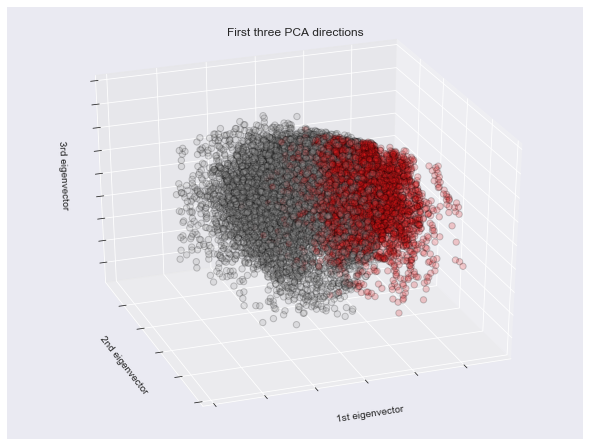

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = PCA(n_components=3).fit_transform(X_std_full)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=Y,
           cmap=plt.cm.Set1, edgecolor='k', s=40, alpha =0.2)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()

### Score 


In [6]:
from sklearn import metrics 
import numpy as np 


def AUC (ypred, ytrue):
	fpr, tpr, thresholds = metrics.roc_curve(ytrue ,ypred, pos_label=1)
	return(metrics.auc(fpr, tpr))

## tuning

In [7]:
from sklearn.model_selection import GridSearchCV # Search over specified parameter values for an estimator.
from sklearn.model_selection import RandomizedSearchCV # Search over specified parameter values for an estimator.
from sklearn.model_selection import ShuffleSplit # Random permutation cross-validator
from sklearn.metrics.scorer import make_scorer
from sklearn.svm import SVC




# regular model 
classifier = SVC(kernel = 'rbf', random_state=42)
cv_sets = ShuffleSplit(random_state = 4) # shuffling our data for cross-validation
parameters = {'gamma':(np.arange(1,40)/20).tolist(),
			  'degree':(np.arange(1,40)/2).tolist(),
			  'C': (np.arange(1,40)/5).tolist(),
			  'coef0' :(np.arange(1,40)/20).tolist()}
scorer = make_scorer(AUC,greater_is_better =True)
n_iter_search = 10
grid_obj = RandomizedSearchCV(classifier, 
                              parameters, 
                              n_iter = n_iter_search, 
                              scoring = scorer, 
                              cv = cv_sets,
                              random_state= 99)
grid_fit = grid_obj.fit(X_train, y_train)
rf_opt = grid_fit.best_estimator_

print(grid_fit.best_estimator_)


SVC(C=6.4, cache_size=200, class_weight=None, coef0=0.7,
  decision_function_shape='ovr', degree=1.5, gamma=0.9, kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)


In [8]:
#pca model 
classifier = SVC(kernel = 'linear', random_state=42)
cv_sets = ShuffleSplit(random_state = 4) # shuffling our data for cross-validation
parameters = {'gamma':(np.arange(1,40)/20).tolist(),
			  'degree':(np.arange(1,40)/2).tolist(),
			  'C': (np.arange(1,40)/5).tolist(),
			  'coef0' :(np.arange(1,40)/20).tolist()}
scorer = make_scorer(AUC,greater_is_better =True)
n_iter_search = 10
grid_obj = RandomizedSearchCV(classifier, 
                              parameters, 
                              n_iter = n_iter_search, 
                              scoring = scorer, 
                              cv = cv_sets,
                              random_state= 99)
grid_fit = grid_obj.fit(pca_train, y_train)
rf_opt = grid_fit.best_estimator_

print(grid_fit.best_estimator_)

SVC(C=6.0, cache_size=200, class_weight=None, coef0=0.45,
  decision_function_shape='ovr', degree=11.0, gamma=0.6, kernel='linear',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)


### Models

In [9]:
from sklearn.svm import SVC

def svclass(xtr, ytr, xte):
	clf = SVC(C=6.4, cache_size=200, class_weight=None, coef0=0.7,
  decision_function_shape='ovr', degree=1.5, gamma=0.9, kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)
	clf.fit(xtr,ytr)

	predict = clf.predict(xte)

	return(predict)

In [14]:
def svclass_pca(xtr, ytr, xte):
	clf = SVC(C=6.0, cache_size=200, class_weight=None, coef0=0.45,
  decision_function_shape='ovr', degree=11.0, gamma=0.6, kernel='rbf',
 max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False)
	clf.fit(xtr,ytr)

	predict = clf.predict(xte)

	return(predict)

### Cross validation


In [10]:
def ten_rerun(model, xtr, ytr):
    auc =[]
    for i in range(10):
        auc_recorder=[]
        kf= KFold(n_splits =10, random_state = i, shuffle= True)
        for train_index, test_index in kf.split(xtr):
            pred= model(xtr.iloc[train_index], ytr.iloc[train_index],xtr.iloc[test_index])
            auc_recorder.append(AUC(pred,ytr.iloc[test_index]))
        auc.append(np.mean(np.array(auc_recorder)))
    return(np.array(auc))
        


In [11]:
def ten_rerun_pca(model, xtr, ytr):
    auc =[]
    for i in range(10):
        auc_recorder=[]
        kf= KFold(n_splits =10, random_state = i, shuffle= True)
        for train_index, test_index in kf.split(xtr):
            pca = PCA(n_components=5)
            pca.fit(xtr.iloc[train_index])
            trx= pca.transform(xtr.iloc[train_index])
            tex = pca.transform(xtr.iloc[test_index])
            pred= model(trx, ytr.iloc[train_index],tex)
            auc_recorder.append(AUC(pred,ytr.iloc[test_index]))
        auc.append(np.mean(np.array(auc_recorder)))
        
    return(np.array(auc))

In [15]:
auc = ten_rerun(svclass,X_std_full,Y)
print(auc)

[0.99526435 0.99576047 0.99622162 0.99570311 0.99632466 0.99538855
 0.99550176 0.99567032 0.99536966 0.99593887]


In [16]:
auc_pca = ten_rerun_pca(svclass_pca,X_std_full,Y)
print(auc_pca)

[0.9412122  0.94028101 0.94109832 0.94134251 0.94060574 0.94015265
 0.93961225 0.94257584 0.94126301 0.94003884]


### two-sided test 

In [17]:
from scipy.stats import wilcoxon

wilcoxon(auc, auc_pca)

WilcoxonResult(statistic=0.0, pvalue=0.005062032126267864)

### one-sided test (R)

> wilcox.test(y, y_auc, alternative = 'less')

	Wilcoxon rank sum test

data:  y and y_auc

W = 100, p-value = 1

alternative hypothesis: true location shift is less than 0

